In [33]:
import os
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, confusion_matrix, accuracy_score, precision_score, recall_score


# Explore the dataset

In [34]:
data_dir = "dataset/chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

Check how many normal and pneumonia images are in each dataset split (train, validation, and test). It’s important because it helps me see if the dataset is balanced or if one class is more common, which can affect how well the model performs. Knowing this helps me decide if I need to use data augmentation or adjust evaluation metrics.

In [35]:
def dataset_info(directory):
    """
    Prints dataset distribution, counting only JPEG.
    """
    normal = sum(1 for file in os.listdir(os.path.join(directory, "NORMAL")) if file.endswith(('.jpeg')))
    pneumonia = sum(1 for file in os.listdir(os.path.join(directory, "PNEUMONIA")) if file.endswith(('.jpeg')))
    total = normal + pneumonia
    print(f"{os.path.basename(directory)} set: Total={total}, Normal={normal} ({normal/total:.1%}), "f"Pneumonia={pneumonia} ({pneumonia/total:.1%})")

for directory in [train_dir, val_dir, test_dir]:
    dataset_info(directory)

train set: Total=5216, Normal=1341 (25.7%), Pneumonia=3875 (74.3%)
val set: Total=16, Normal=8 (50.0%), Pneumonia=8 (50.0%)
test set: Total=624, Normal=234 (37.5%), Pneumonia=390 (62.5%)


The class distribution isn’t consistent across the train, validation, and test sets. It might be better to combine them and split again to keep the class balance more even.

In [36]:
image_paths = []
labels = []
def add_images(directory):
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith('.jpeg'):
                    image_path = os.path.join(label_dir, image_name)
                    image_paths.append(image_path)
                    labels.append(label)

for directory in [train_dir, test_dir, val_dir]:
    add_images(directory)

# Create DF
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(df.head())
print(df.shape)
print("\nUnique labels:", df["label"].unique())
print("\nLabel counts:")
print(df["label"].value_counts())

                                          image_path      label
0  dataset/chest_xray/train/PNEUMONIA/person63_ba...  PNEUMONIA
1  dataset/chest_xray/train/PNEUMONIA/person1438_...  PNEUMONIA
2  dataset/chest_xray/train/PNEUMONIA/person755_b...  PNEUMONIA
3  dataset/chest_xray/train/PNEUMONIA/person478_v...  PNEUMONIA
4  dataset/chest_xray/train/PNEUMONIA/person661_b...  PNEUMONIA
(5856, 2)

Unique labels: ['PNEUMONIA' 'NORMAL']

Label counts:
label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


Randomly pick and plots 8 images from the "NORMAL" and "PNEUMONIA" categories. It’s useful for visually inspecting the images and making sure the data looks correct before feeding it into the model. It also helps me get a sense of the quality and diversity of the images in each category.

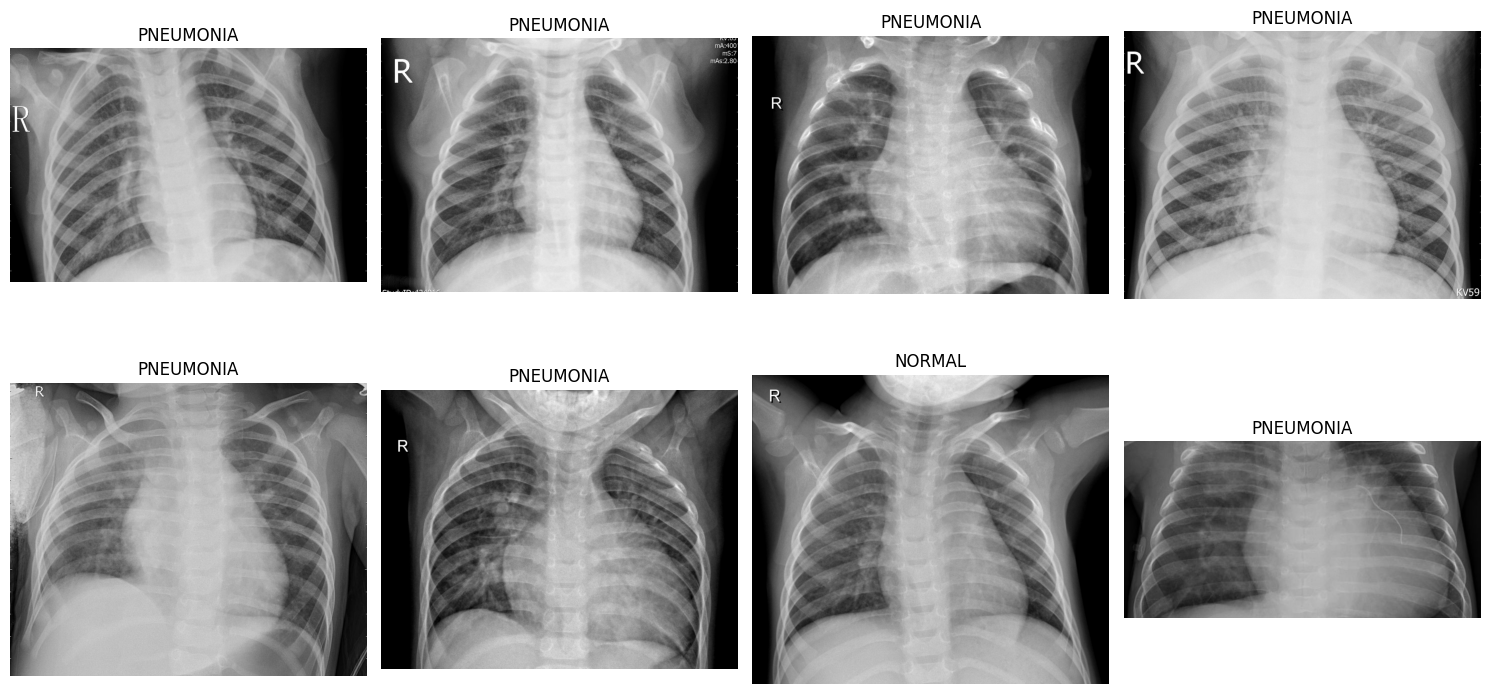

In [37]:
def plot_random_images(df, num_images=8):
    sampled_df = df.sample(n=num_images)

    plt.figure(figsize=(15, 8))

    for i, (index, row) in enumerate(sampled_df.iterrows()):
        img_path = row['image_path']
        img = cv2.imread(img_path)
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(row['label'])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images(df)


In [38]:
def image_properties(df, num_samples=20):
    sample_df = df.sample(n=num_samples) 
    widths, heights, min_intensities, max_intensities, mean_intensities = [], [], [], [], []
    all_intensities = []
    
    for img_path in sample_df["image_path"]:
        img = cv2.imread(img_path)
        
        height, width, channels = img.shape
        widths.append(width)
        heights.append(height)
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        min_intensities.append(img_gray.min())
        max_intensities.append(img_gray.max())
        mean_intensities.append(img_gray.mean())
        
        all_intensities.extend(img_gray.flatten())

    # Dimensions
    print(f"Dimensions (from {num_samples} randomly sampled images):")
    print(f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
    print(f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
    
    # Intensity
    print(f"\nIntensity values:")
    print(f"Min Intensity: min={min(min_intensities)}, max={max(min_intensities)}, mean={np.mean(min_intensities):.1f}")
    print(f"Max Intensity: min={min(max_intensities)}, max={max(max_intensities)}, mean={np.mean(max_intensities):.1f}")
    print(f"Mean Intensity: min={min(mean_intensities)}, max={max(mean_intensities)}, mean={np.mean(mean_intensities):.1f}")
    
image_properties(df)

Dimensions (from 20 randomly sampled images):
Width: min=806, max=2348, mean=1312.3
Height: min=468, max=1920, mean=988.6

Intensity values:
Min Intensity: min=0, max=8, mean=0.4
Max Intensity: min=205, max=255, mean=247.8
Mean Intensity: min=76.40871663464682, max=143.80248681578468, mean=118.2


Randomly pick image from the training set, checks size, color type, and pixel values, then plot it. This helps to understand the image's properties before using it in the model.

Dimensions: 238 pixels (height) x 462 pixels (width)
Color Type: Color
Max Pixel Value: 253
Min Pixel Value: 0


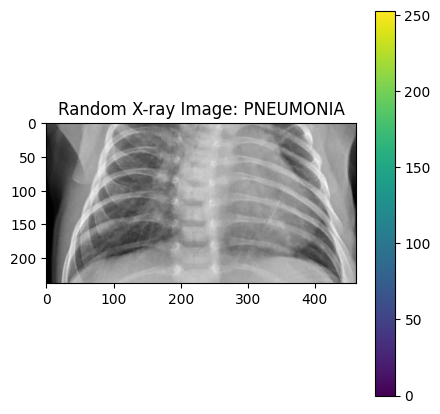

In [39]:
def image_with_details(df):
    sampled_row = df.sample(n=1).iloc[0]
    img_path = sampled_row['image_path']
    img = cv2.imread(img_path)

    height, width, channels = img.shape
    max_pixel_value = img.max()
    min_pixel_value = img.min()

    color = 'Color' if channels == 3 else 'Grayscale'

    print(f"Dimensions: {height} pixels (height) x {width} pixels (width)")
    print(f"Color Type: {color}")
    print(f"Max Pixel Value: {max_pixel_value}")
    print(f"Min Pixel Value: {min_pixel_value}")

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.colorbar()
    plt.title(f"Random X-ray Image: {sampled_row['label']}")
    plt.show()

image_with_details(df)

# Split dataset

Common approach for split small datasets:
* Training set: 70-80%
* Validation set: 10-15%
* Test set: 10-15%

For this project I'll use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split into 80% - 10% - 10%



In [40]:
# ShuffleDataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split | 80% training, 10% validation, and 10% test
train_df, temp = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df["label"])  
val_df, test_df = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42, stratify=temp["label"]) 

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4684
Validation set size: 586
Test set size: 586


Check distribution in each df

In [41]:
def dataset_distribution(df, set_name):
    """
    Prints the dataset distribution for a given DataFrame.
    """
    normal_count = (df["label"] == "NORMAL").sum()
    pneumonia_count = (df["label"] == "PNEUMONIA").sum()
    total = len(df)

    print(f"{set_name} Set: Total={total}, "
        f"Normal={normal_count} ({normal_count/total:.1%}), "
        f"Pneumonia={pneumonia_count} ({pneumonia_count/total:.1%})")

dataset_distribution(train_df, "Train")
dataset_distribution(val_df, "Validation")
dataset_distribution(test_df, "Test")

Train Set: Total=4684, Normal=1266 (27.0%), Pneumonia=3418 (73.0%)
Validation Set: Total=586, Normal=159 (27.1%), Pneumonia=427 (72.9%)
Test Set: Total=586, Normal=158 (27.0%), Pneumonia=428 (73.0%)


There is a class imbalance, which may lead to poor generalization for the minority class. This DataFrame could benefit from applying [techniques for handling class imbalance](https://medium.com/@okeshakarunarathne/handling-class-imbalance-in-image-classification-techniques-and-best-practices-c539214440b0)

In [42]:
# DataFrames to CSV
train_df.to_csv('dataset/train_set.csv', index=False)
val_df.to_csv('dataset/val_set.csv', index=False)
test_df.to_csv('dataset/test_set.csv', index=False)

# PREPROCESS

In [43]:
def preprocess_image(image_path, size=224, apply_clahe=True, apply_gaussian_blur=True):
    """
    Preprocess the image by applying selected transformations such as resizing, CLAHE, and Gaussian blur.
    """
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image
    img = cv2.resize(img, (size, size))

    # CLAHE: Contrast Limited Adaptive Histogram Equalization
    if apply_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

    # Gaussian Blur
    if apply_gaussian_blur:
        img = cv2.GaussianBlur(img, (3, 3), 0)

    # Normalize pixel values [0, 1]
    img = img / 255.0

    # Add channel dimension
    img = np.stack([img, img, img], axis=-1)

    return img

def process_dataframe(df, size=224, apply_clahe=True, apply_gaussian_blur=True):
    """
    Process the dataset from a DataFrame containing image paths and labels.
    """
    images = []
    labels = []
    class_counts = {"NORMAL": 0, "PNEUMONIA": 0}

    for _, row in df.iterrows():
        img_path = row['image_path']
        label = row['label']

        img = preprocess_image(
            img_path, 
            size=size, 
            apply_clahe=apply_clahe, 
            apply_gaussian_blur=apply_gaussian_blur
        )

        images.append(img)
        labels.append(0 if label == "NORMAL" else 1)
        class_counts[label] += 1

    print(f"Processed {sum(class_counts.values())} images: {class_counts}")

    return np.array(images), np.array(labels)

X_train, y_train = process_dataframe(train_df)
X_val, y_val = process_dataframe(val_df)
X_test, y_test = process_dataframe(test_df)


Processed 4684 images: {'NORMAL': 1266, 'PNEUMONIA': 3418}
Processed 586 images: {'NORMAL': 159, 'PNEUMONIA': 427}
Processed 586 images: {'NORMAL': 158, 'PNEUMONIA': 428}


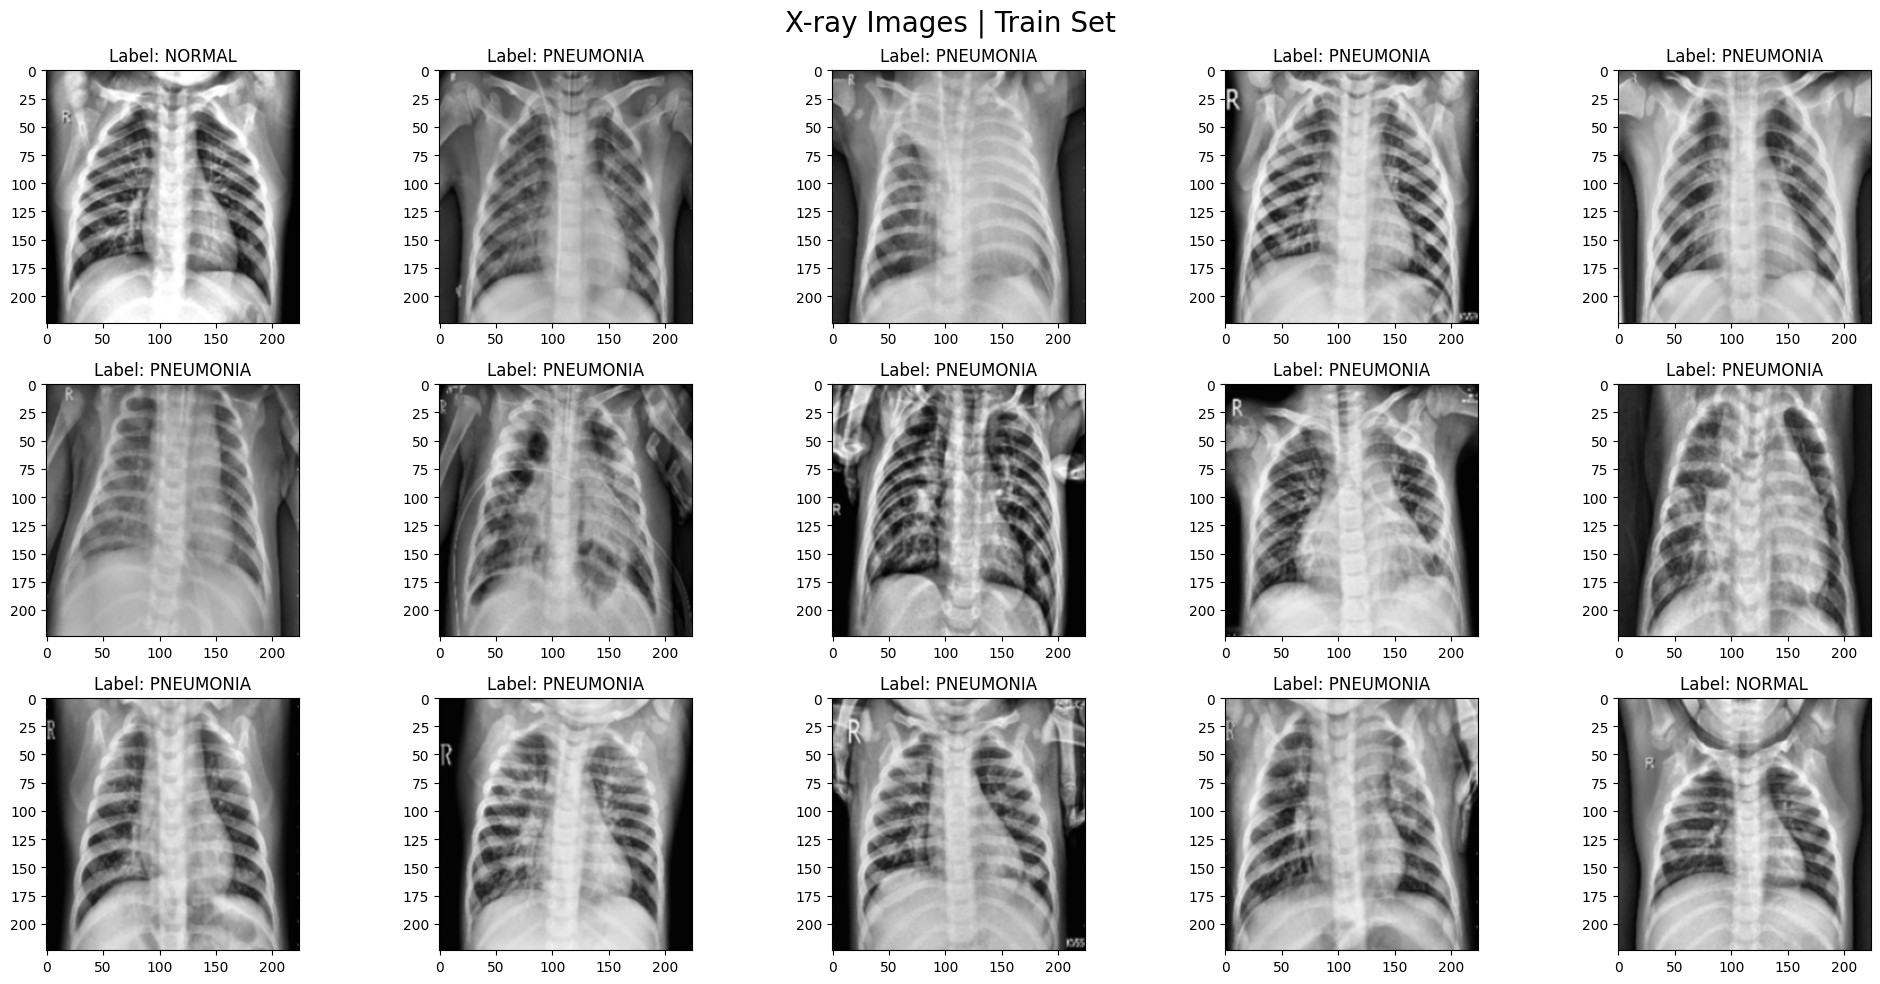

In [44]:
def plot_images(images, labels, num_images=15):
    plt.figure(figsize=(20, 10))
    plt.suptitle('X-ray Images | Train Set', fontsize=20)

    random_indices = random.sample(range(len(images)), num_images)

    for i, idx in enumerate(random_indices):
        img = images[idx]
        label = 'NORMAL' if labels[idx] == 0 else 'PNEUMONIA'
        
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train, num_images=15)

***

# Model

[Improving Class Imbalance](https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4): Calculating class weights is an important step in handling class imbalance in machine learning. The goal is to determine appropriate weights that give more importance to the minority class and less importance to the majority class during model training. There are different approaches to calculate class weights, and one common method is the Inverse Class Frequency method.

In [45]:
def calculate_class_weights(y_train):
    labels = y_train.numpy() if hasattr(y_train, 'numpy') else y_train
    
    class_0_count = np.sum(labels == 0)
    class_1_count = np.sum(labels == 1)
    total_samples = len(labels)
    
    # Calculate weights using inverse frequency
    weight_0 = total_samples / (2 * class_0_count)  
    weight_1 = total_samples / (2 * class_1_count)  

    class_weights = {0: weight_0, 1: weight_1}
    
    return class_weights

class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)


Class weights: {0: 1.8499210110584519, 1: 0.6851960210649503}


[Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation): a technique to increase the diversity of your training set by applying random (but realistic) transformations. It is apply only to training set as the goal is to expose the model to more variation during training to improve generalization. 

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

[EfficientNetB0](https://keras.io/api/applications/efficientnet/#efficientnetb0-function)
* Size (MB): 29	
* Top-1 Accuracy: 77.1%	
* Top-5 Accuracy: 93.3%	
* Parameters: 5.3M	
* Depth: 132	
* Time (ms) per inference step (CPU): 46.0	
* Time (ms) per inference step (GPU): 4.9

In [47]:
def build_model(input_shape):
    """
    Build an model with EfficientNetB0 as base and freeze a percentage of layers.
    """
    # Load EfficientNetB0 as base
    base_model = EfficientNetB0(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape, 
        pooling='avg'
    )
    
    # Freeze a percentage of base layers
    num_freeze = int(len(base_model.layers) * 0.2) # Freezing 20% layers
    for layer in base_model.layers[:num_freeze]:
        layer.trainable = False
    for layer in base_model.layers[num_freeze:]:
        layer.trainable = True

    # Build model
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01),
                    bias_regularizer=regularizers.l1(0.0003)),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    return model, base_model

model, base_model = build_model((224, 224, 3))

In [48]:
# Stage 1: Train only top layers
print("Stage 1: Training top layers only")

# Compile the model 
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

# Define callbacks | Stage 1
model_checkpoint = "model_checkpoint/EfficientNetB0_best_model_stage1.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-5, verbose=1),
    ModelCheckpoint(filepath=model_checkpoint, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

# Fit the model | Stage 1
history_stage1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1,
    class_weight=class_weights,
    callbacks=callbacks
)

Stage 1: Training top layers only
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6627 - auc: 0.7642 - loss: 7.9906 - precision: 0.8746 - recall: 0.6219
Epoch 1: val_accuracy improved from -inf to 0.35666, saving model to model_checkpoint/EfficientNetB0_best_model_stage1.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step - accuracy: 0.6631 - auc: 0.7646 - loss: 7.9896 - precision: 0.8750 - recall: 0.6222 - val_accuracy: 0.3567 - val_auc: 0.6502 - val_loss: 7.8881 - val_precision: 0.8378 - val_recall: 0.1452 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.7850 - auc: 0.9106 - loss: 7.5768 - precision: 0.9557 - recall: 0.7374
Epoch 2: val_accuracy improved from 0.35666 to 0.72867, saving model to model_checkpoint/EfficientNetB0_best_model_stage1.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 0.7850 - auc: 0.9107 - loss: 7.5764 - precision: 0.9557 - recall: 0.7375 - val_accuracy: 0.7287 - val_auc: 0.5850 - v

In [49]:
# Stage 2: Fine-tuning the base model
print("Stage 2: Fine-tuning the base model")

base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

# Define callbacks | Stage 2
model_checkpoint = "model_checkpoint/EfficientNetB0_best_model_stage2.keras"
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(filepath=model_checkpoint, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

# Fit the model | Stage 2
history_stage2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    verbose=1,
    class_weight=class_weights,
    callbacks=callbacks
)

Stage 2: Fine-tuning the base model
Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8754 - auc: 0.9546 - loss: 6.3357 - precision: 0.9571 - recall: 0.8662
Epoch 1: val_accuracy improved from -inf to 0.89761, saving model to model_checkpoint/EfficientNetB0_best_model_stage2.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 398ms/step - accuracy: 0.8754 - auc: 0.9546 - loss: 6.3355 - precision: 0.9572 - recall: 0.8662 - val_accuracy: 0.8976 - val_auc: 0.9565 - val_loss: 6.1546 - val_precision: 0.8913 - val_recall: 0.9789 - learning_rate: 1.0000e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.8806 - auc: 0.9582 - loss: 6.1792 - precision: 0.9650 - recall: 0.8664
Epoch 2: val_accuracy did not improve from 0.89761
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 344ms/step - accuracy: 0.8805 - auc: 0.9581 - loss: 6.1792 - precision: 0.9650 - recall: 0.8663 - val_accuracy: 0.8891 - val_auc: 0.9541 - val_loss: 6.0331 - val_precision: 0.8755 - val_recall: 0.9883 - learning_rat

***

# Evaluation Metrics

**1. Loss**: It measures how far the model's predictions are from the actual labels during training and evaluation. It is computed using a loss function, [binary cross-entropy](https://medium.com/towards-data-science/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a), for binary classification problems. It's is useful for tracking training progress but doesn’t always directly correlate with accuracy.  
- **How to interpret**:  
  - **Lower loss** → Better performance (predictions are closer to actual labels).  
  - **Higher loss** → Worse performance (more incorrect predictions).  

**2. Accuracy**:Accuracy is the percentage of correctly classified instances out of all instances. Accuracy alone is not reliable for imbalanced datasets because it does not account for false positives and false negatives.  
$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}
$$
- **How to interpret**:  
  - **High accuracy (>85%)** → Model classifies most images correctly.  
  - **Low accuracy (<50%)** → Model struggles to distinguish between classes.  

**3. AUC (Area Under the ROC Curve)**: AUC-ROC measures how well the model distinguishes between classes across different probability thresholds.  AUC helps measure the trade-off between sensitivity (recall) and specificity (true negative rate), making it useful for imbalanced datasets.  
  Derived from the **Receiver Operating Characteristic (ROC) curve**, which plots **True Positive Rate (Recall)** vs. **False Positive Rate** at various thresholds.  
- **How to interpret**:  
  - **AUC = 1.0** → Perfect classifier (ideal).  
  - **AUC = 0.5** → Random guessing (bad model).  
  - **AUC > 0.9** → Excellent discrimination between classes.  

**4. Precision**: Precision tells us how many of the positive predictions (PNEUMONIA) were actually correct. 
$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$
- **How to interpret**:  
  - **High precision (>95%)** → Few false positives (model is confident in its pneumonia predictions).  
  - **Low precision** → Many false positives (model incorrectly predicts PNEUMONIA too often).  

**5. Recall (Sensitivity or True Positive Rate)**: Recall tells us how many of the actual positive cases (PNEUMONIA) were correctly identified.  
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$
- **How to interpret**:  
  - **High recall (>80%)** → The model correctly detects most pneumonia cases.  
  - **Low recall** → The model misses many pneumonia cases (false negatives).  

**5. F1 Score**: It is the harmonic mean of Precision and Recall. It provides a single metric that balances both, making it useful when you need a trade-off between precision and recall.
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- **How to interpret**:  
  - **High F1 Score (close to 1)**: The model has both high Precision** (few false positives) and high Recall (few false negatives). This means it correctly identifies most positive cases while making few incorrect positive predictions. A perfect model has an F1 score of 1.
  - **Low F1 Score (close to 0)**: The model performs poorly, either because it has low Precision (too many false positives) or low Recall (too many false negatives).


References: 
* [A Comprehensive Guide to Performance Metrics in Machine Learning](https://medium.com/@abhishekjainindore24/a-comprehensive-guide-to-performance-metrics-in-machine-learning-4ae5bd8208ce)
* [Mastering ML Metrics: Definitions, Mathematics, and Implementation](https://medium.com/@sayedebad.777/mastering-ml-metrics-definitions-mathematics-and-implementation-9a9bd9a46df8)

In [50]:
print(history_stage1.history.keys())
print(history_stage2.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])
dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


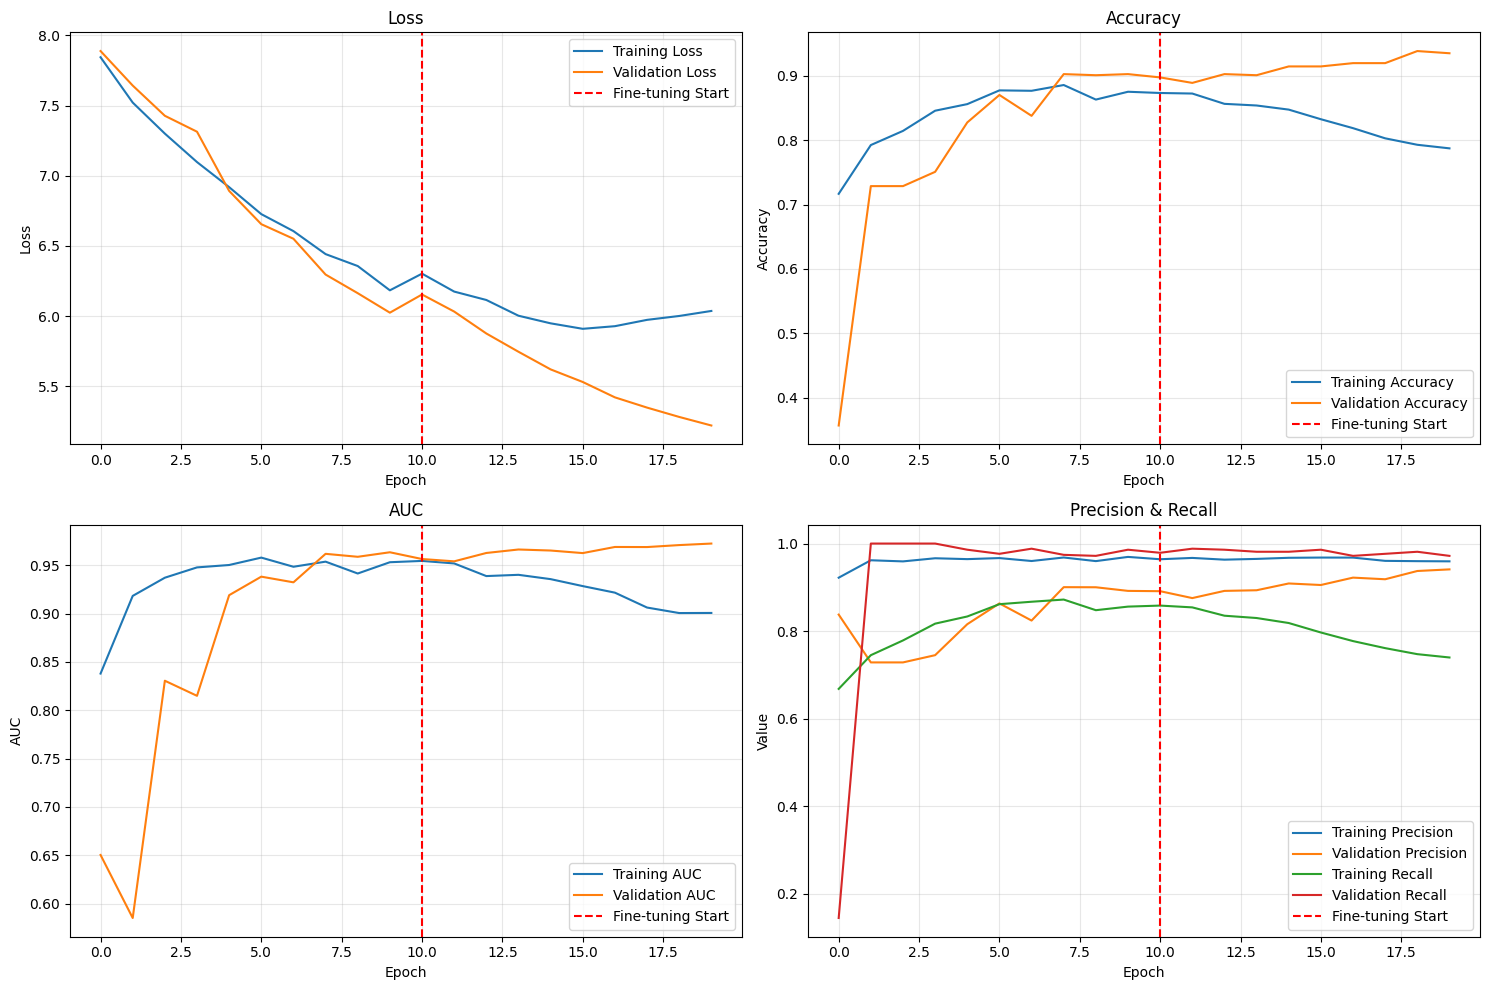

In [51]:
def plot_training_history(history_stage1, history_stage2):
    """
    Plot training history with loss, accuracy, AUC, precision, and recall.
    """
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    combined_history = {m: history_stage1.history[m] + history_stage2.history[m] for m in metrics}
    combined_history.update({f'val_{m}': history_stage1.history[f'val_{m}'] + history_stage2.history[f'val_{m}'] for m in metrics})
    
    epochs_stage1 = len(history_stage1.history['loss'])
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss, Accuracy, AUC
    metric_pairs = [('loss', 'Loss'), ('accuracy', 'Accuracy'), ('auc', 'AUC')]
    for ax, (metric, title) in zip(axs.flat, metric_pairs):
        ax.plot(combined_history[metric], label=f'Training {title}')
        ax.plot(combined_history[f'val_{metric}'], label=f'Validation {title}')
        ax.axvline(x=epochs_stage1, color='r', linestyle='--', label='Fine-tuning Start')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Precision & Recall
    axs[1, 1].plot(combined_history['precision'], label='Training Precision')
    axs[1, 1].plot(combined_history['val_precision'], label='Validation Precision')
    axs[1, 1].plot(combined_history['recall'], label='Training Recall')
    axs[1, 1].plot(combined_history['val_recall'], label='Validation Recall')
    axs[1, 1].axvline(x=epochs_stage1, color='r', linestyle='--', label='Fine-tuning Start') 
    axs[1, 1].set_title('Precision & Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/training_validation_metrics_overview', dpi=300)
    plt.show()

plot_training_history(history_stage1, history_stage2)

**ROC Curve**: The ROC (Receiver Operating Characteristic) curve is a graphical representation of a classifier's performance across various classification thresholds. It shows the tradeoff between the True Positive Rate (TPR) and False Positive Rate (FPR) at different threshold values. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise.’ In other words, it shows the performance of a classification model at all classification thresholds.

**PR Curve**: The Precision-Recall (PR) curve is an evaluation metric for binary classification and useful when dealing with imbalanced datasets. It plots the Precision versus Recall at different thresholds. The PR curve plots Recall (y-axis) against Precision (x-axis) for various thresholds. It provides a clearer picture of the classifier's ability to predict the positive class, particularly in imbalanced datasets where the negative class heavily outweighs the positive class.

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step


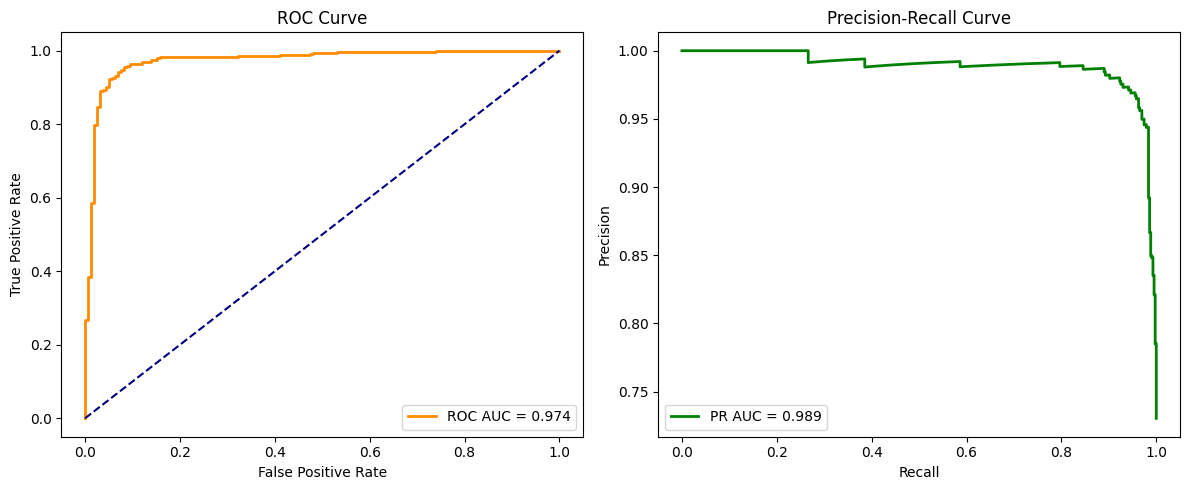

In [52]:
def plot_roc_pr_curves(y_test):
    """
    ROC and Precision-Recall curves.
    """
    y_pred_prob = model.predict(X_test, verbose=1)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = average_precision_score(y_test, y_pred_prob)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    axs[0].plot([0, 1], [0, 1], 'navy', linestyle='--')
    axs[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')
    axs[0].legend()
    
    axs[1].plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR AUC = {pr_auc:.3f}')
    axs[1].set(xlabel='Recall', ylabel='Precision', title='Precision-Recall Curve')
    axs[1].legend()
    
    plt.tight_layout()
    plt.savefig('plots/roc_pr_curves.png', dpi=300)
    plt.show()

plot_roc_pr_curves(y_test)

In [53]:
def evaluate_model(model, X_test, y_test, class_names=['NORMAL', 'PNEUMONIA'], thresholds=[0.3, 0.4, 0.5, 0.6, 0.7]):
    """Evaluate model, print metrics, and return evaluation results."""
    # Evaluation
    test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_prob = model.predict(X_test, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    
    # Metrics
    accuracy = np.mean(y_pred == y_test)
    precision = np.sum((y_pred == 1) & (y_test == 1)) / (np.sum(y_pred == 1) + 1e-10)
    recall = np.sum((y_pred == 1) & (y_test == 1)) / (np.sum(y_test == 1) + 1e-10)
    f1 = f1_score(y_test, y_pred)
    roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
    pr_auc = average_precision_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred, target_names=class_names)
    
    # Evaluation metrics
    print(f"\nModel Evaluation Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}\nPR AUC: {pr_auc:.4f}\n")
    print("Classification Report:")
    print(report)
    
    # Metrics at different thresholds
    print("\nMetrics at Different Thresholds:")
    print(f"{'Threshold':<10}{'Accuracy':<10}{'Precision':<10}{'Recall':<10}{'F1 Score':<10}")
    for threshold in thresholds:
        y_pred_t = (y_pred_prob > threshold).astype(int).reshape(-1)
        accuracy_t = np.mean(y_pred_t == y_test)
        precision_t = np.sum((y_pred_t == 1) & (y_test == 1)) / (np.sum(y_pred_t == 1) + 1e-10)
        recall_t = np.sum((y_pred_t == 1) & (y_test == 1)) / (np.sum(y_test == 1) + 1e-10)
        f1_t = 2 * precision_t * recall_t / (precision_t + recall_t + 1e-10)
        print(f"{threshold:<10.1f}{accuracy_t:<10.4f}{precision_t:<10.4f}{recall_t:<10.4f}{f1_t:<10.4f}")
    
    return {'accuracy': test_acc, 'precision': test_precision, 'recall': test_recall, 'f1': f1,
            'roc_auc': test_auc, 'pr_auc': pr_auc, 'y_pred': y_pred, 'y_pred_prob': y_pred_prob}

evaluation_results = evaluate_model(model, X_test, y_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9376 - auc: 0.9701 - loss: 5.2803 - precision: 0.9517 - recall: 0.9631
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

Model Evaluation Metrics:
Accuracy: 0.9420
Precision: 0.9518
Recall: 0.9696
F1 Score: 0.9606
ROC AUC: 0.9743
PR AUC: 0.9886

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.87      0.89       158
   PNEUMONIA       0.95      0.97      0.96       428

    accuracy                           0.94       586
   macro avg       0.93      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586


Metrics at Different Thresholds:
Threshold Accuracy  Precision Recall    F1 Score  
0.3       0.9437    0.9418    0.9836    0.9623    
0.4       0.9420    0.9498    0.9720    0.9607    
0.5       0.9420    0.9518    0.9696    0.9606    
0.6       0.9420    0.9581    0.9626    0.9604    
0.7       0.9437    0.9691    0.9533    0.9611    


The model does a great job dealing with the class imbalance between "Pneumonia" and "Normal" categories, giving high precision and recall for both. The Pneumonia class stands out with a really high recall (97%), meaning it does a good job catching most of the pneumonia cases and minimizing false negatives. When testing at different thresholds, the model showed solid performance, with the best balance of precision and recall at a threshold of 0.5.

**Confusion Matrix**: It tabulates true positive, true negative, false positive, and false negative predictions of a classification model.

- Structure of the Confusion Matrix:

|                     | Predicted: 0 (NORMAL) | Predicted: 1 (PNEUMONIA) |
|---------------------|-----------------------|--------------------------|
| **Actual: 0** (NORMAL)   | True Negative (TN)     | False Positive (FP)       |
| **Actual: 1** (PNEUMONIA) | False Negative (FN)    | True Positive (TP)        |

Where:
- **True Positives (TP)**: The number of instances where the model correctly predicted the positive class (PNEUMONIA).
- **False Positives (FP)**: The number of instances where the model incorrectly predicted the positive class (PNEUMONIA) when it should have been the negative class (NORMAL).
- **True Negatives (TN)**: The number of instances where the model correctly predicted the negative class (NORMAL).
- **False Negatives (FN)**: The number of instances where the model incorrectly predicted the negative class (NORMAL) when it should have been the positive class (PNEUMONIA).

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


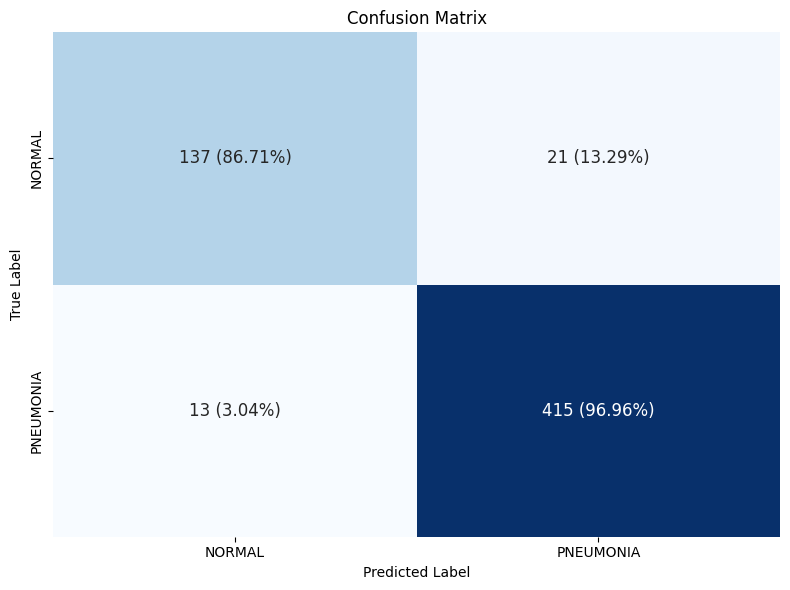

In [54]:
def plot_confusion_matrix(model, X_test, y_true, class_names=['NORMAL', 'PNEUMONIA']):
    """
    Plot a confusion matrix with raw counts and percentages in one plot.
    """
    y_pred_prob = model.predict(X_test, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Combine number and percentage into one string
    cm_display = np.empty_like(cm, dtype=object)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            cm_display[i, j] = f"{cm[i, j]} ({cm_norm[i, j] * 100:.2f}%)"
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=cm_display, fmt='', cmap="Blues", cbar=False, 
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    
    # Save plot
    plt.tight_layout()
    plt.savefig('plots/confusion_matrix.png', dpi=300)
    plt.show()

    return {'plots/confusion_matrix': cm}

# Example usage:
cm_results = plot_confusion_matrix(model, X_test, y_test)


***

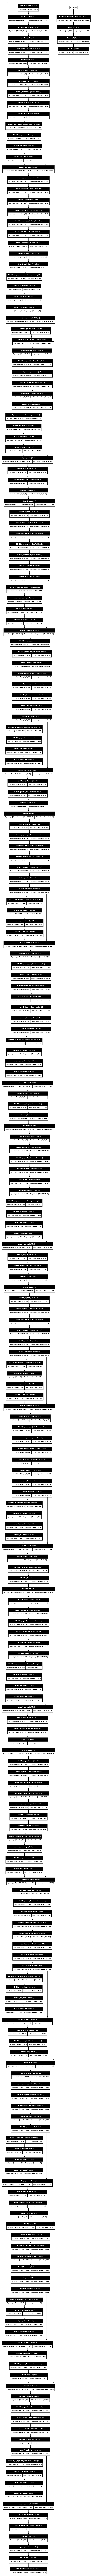

In [55]:
plot_model(model, 
        to_file='plots/model_architecture.png', 
        show_shapes=True, 
        show_layer_names=True, 
        expand_nested=True, 
        dpi=50) 